In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install pyarrow

### Setup

Let's setup Spark on your Colab environment.  Run the cell below!

In [4]:
!apt update

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [696 B]
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:8 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:9 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:11 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [73.9 kB]
Hit:12 http://ppa.launchpad.net/cran/

In [5]:
!apt-get install openjdk-8-jdk-headless 

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 2 newly installed, 0 to remove and 79 not upgraded.
Need to get 36.5 MB of archives.
After this operation, 143 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 openjdk-8-jre-headless amd64 8u312-b07-0ubuntu1~18.04 [28.2 MB]
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 openjdk-8-jdk-headless amd64 8u312-b07-0ubuntu1~18.04 [8,298 kB]
Fetched 36.5 MB in 3s (11.4 MB/s)
Selecting previously unselected package openjdk-8-jre-headless:amd64.
(Reading database

In [6]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

In [7]:
!pip install pyspark
!pip install -U -q PyDrive

     |████████████████████████████████| 281.3 MB 36 kB/s 
     |████████████████████████████████| 198 kB 52.1 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.0-py2.py3-none-any.whl size=281805912 sha256=14c617fbd33a5bc54aaae68c3e5323949325d0188bd60fa2c4c65dafb2b5003b
  Stored in directory: /root/.cache/pip/wheels/0b/de/d2/9be5d59d7331c6c2a7c1b6d1a4f463ce107332b1ecd4e80718
Successfully built pyspark


Now we authenticate a Google Drive client to download the file we will be processing in our Spark job.

**Make sure to follow the interactive instructions.**

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pyspark
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

import pyarrow

## Libraries

In [76]:
from pyspark.sql.functions import *
from functools import reduce
from pyspark.ml.classification import  RandomForestClassifier
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, VectorSlicer
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.linalg import Vectors
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
import seaborn as sns
from sklearn.metrics import classification_report

Let's initialize the Spark context.

In [10]:
# create the session
conf = SparkConf().set("spark.ui.port", "4050")

# create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

In [11]:
spark

## Load Data

In [12]:
df = spark.read.csv("/content/drive/MyDrive/UNSW-NB15.csv", inferSchema=True)

## Renaming the columns

### Using withColumnRenamed, notice that this method allows you to "overwrite" the same column. For Python3, replace xrange with range.

In [13]:
oldColumns = df.schema.names

In [14]:
newColumns = ['srcip', 'sport', 'dstip', 'dsport', 'proto', 'state', 'dur',
       'sbytes', 'dbytes', 'sttl', 'dttl', 'sloss', 'dloss', 'service',
       'Sload', 'Dload', 'Spkts', 'Dpkts', 'swin', 'dwin', 'stcpb',
       'dtcpb', 'smeansz', 'dmeansz', 'trans_depth', 'res_bdy_len',
       'Sjit', 'Djit', 'Stime', 'Ltime', 'Sintpkt', 'Dintpkt', 'tcprtt',
       'synack', 'ackdat', 'is_sm_ips_ports', 'ct_state_ttl',
       'ct_flw_http_mthd', 'is_ftp_login', 'ct_ftp_cmd', 'ct_srv_src',
       'ct_srv_dst', 'ct_dst_ltm', 'ct_src_ ltm', 'ct_src_dport_ltm',
       'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'attack_cat', 'Label']

In [15]:
df = reduce(lambda df, idx: df.withColumnRenamed(oldColumns[idx], newColumns[idx]), range(len(oldColumns)), df)

In [16]:
print("Total Numbers of rows in the dataset are {0} ".format(df.count()))

Total Numbers of rows in the dataset are 2539739 


## Columns Creating Hive Table to See Rows

In [106]:
df.createOrReplaceTempView("UNSWs")
UNSW = spark.sql("SELECT * FROM UNSWs")
UNSW.show()

+----------+-----+-------------+------+-----+-----+------------+------+------+----+----+-----+-----+--------+---------+---------+-----+-----+----+----+----------+----------+-------+-------+-----------+-----------+----------+---------+----------+----------+------------+------------+------------+------------+------------+---------------+------------+----------------+------------+----------+----------+----------+----------+-----------+----------------+----------------+--------------+----------+-----+
|     srcip|sport|        dstip|dsport|proto|state|         dur|sbytes|dbytes|sttl|dttl|sloss|dloss| service|    Sload|    Dload|Spkts|Dpkts|swin|dwin|     stcpb|     dtcpb|smeansz|dmeansz|trans_depth|res_bdy_len|      Sjit|     Djit|     Stime|     Ltime|     Sintpkt|     Dintpkt|      tcprtt|      synack|      ackdat|is_sm_ips_ports|ct_state_ttl|ct_flw_http_mthd|is_ftp_login|ct_ftp_cmd|ct_srv_src|ct_srv_dst|ct_dst_ltm|ct_src_ ltm|ct_src_dport_ltm|ct_dst_sport_ltm|ct_dst_src_ltm|attack_cat|L

In [107]:
spark.sql("show tables").show()

+---------+---------+-----------+
|namespace|tableName|isTemporary|
+---------+---------+-----------+
|         |     unsw|       true|
|         |    unsws|       true|
+---------+---------+-----------+



## Descriptive Statistics

## Describtion for Numeric Columns

Statisical Summary of each numerical column in the dataframe  which summarize the central tendency, dispersion and shape of a dataset’s distribution, excluding NaN values.

* DataFrame.count : Count number of non-NA/null observations.
* DataFrame.max: Maximum of the values in the object.
* DataFrame.min : Minimum of the values in the object.
* DataFrame.mean : Mean of the values.

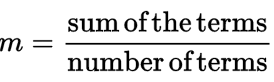
* DataFrame.std : Standard deviation of the observations.

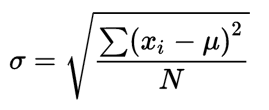
* DataFrame.select_dtypes : Subset of a DataFrame including/excluding columns based on their dtype.



In [ ]:
UNSW.describe().show()

+-------+-----------+------------------+-----------+------------------+-------+-------+------------------+-----------------+------------------+-----------------+------------------+-----------------+------------------+-------+--------------------+-----------------+-----------------+------------------+------------------+------------------+--------------------+--------------------+------------------+------------------+-------------------+------------------+------------------+------------------+--------------------+--------------------+------------------+-----------------+--------------------+--------------------+-------------------+--------------------+-------------------+-------------------+-------------------+--------------------+------------------+------------------+-----------------+-----------------+-----------------+-----------------+------------------+----------+-------------------+
|summary|      srcip|             sport|      dstip|            dsport|  proto|  state|             

## Data Preprocessing

In [ ]:
UNSW.printSchema()

root
 |-- srcip: string (nullable = true)
 |-- sport: integer (nullable = true)
 |-- dstip: string (nullable = true)
 |-- dsport: integer (nullable = true)
 |-- proto: string (nullable = true)
 |-- state: string (nullable = true)
 |-- dur: double (nullable = true)
 |-- sbytes: integer (nullable = true)
 |-- dbytes: integer (nullable = true)
 |-- sttl: integer (nullable = true)
 |-- dttl: integer (nullable = true)
 |-- sloss: integer (nullable = true)
 |-- dloss: integer (nullable = true)
 |-- service: string (nullable = true)
 |-- Sload: double (nullable = true)
 |-- Dload: double (nullable = true)
 |-- Spkts: integer (nullable = true)
 |-- Dpkts: integer (nullable = true)
 |-- swin: integer (nullable = true)
 |-- dwin: integer (nullable = true)
 |-- stcpb: long (nullable = true)
 |-- dtcpb: long (nullable = true)
 |-- smeansz: integer (nullable = true)
 |-- dmeansz: integer (nullable = true)
 |-- trans_depth: integer (nullable = true)
 |-- res_bdy_len: integer (nullable = true)
 |-- S

## Fill Null Values in attack_cat with Begine(Normal)

In [18]:
UNSW = UNSW.na.fill(value='benign',subset=["attack_cat"])

In [19]:
UNSW.show(5)

+----------+-----+-------------+------+-----+-----+-----------+------+------+----+----+-----+-----+-------+---------+---------+-----+-----+----+----+----------+----------+-------+-------+-----------+-----------+---------+---------+----------+----------+---------+----------+------------+------------+------------+---------------+------------+----------------+------------+----------+----------+----------+----------+-----------+----------------+----------------+--------------+----------+-----+
|     srcip|sport|        dstip|dsport|proto|state|        dur|sbytes|dbytes|sttl|dttl|sloss|dloss|service|    Sload|    Dload|Spkts|Dpkts|swin|dwin|     stcpb|     dtcpb|smeansz|dmeansz|trans_depth|res_bdy_len|     Sjit|     Djit|     Stime|     Ltime|  Sintpkt|   Dintpkt|      tcprtt|      synack|      ackdat|is_sm_ips_ports|ct_state_ttl|ct_flw_http_mthd|is_ftp_login|ct_ftp_cmd|ct_srv_src|ct_srv_dst|ct_dst_ltm|ct_src_ ltm|ct_src_dport_ltm|ct_dst_sport_ltm|ct_dst_src_ltm|attack_cat|Label|
+---------

## Check Null

In [ ]:
from pyspark.sql.functions import col,sum
UNSW.select(*(sum(col(c).isNull().cast("int")).alias(c) for c in UNSW.columns)).show()

+-----+-----+-----+------+-----+-----+---+------+------+----+----+-----+-----+-------+-----+-----+-----+-----+----+----+-----+-----+-------+-------+-----------+-----------+----+----+-----+-----+-------+-------+------+------+------+---------------+------------+----------------+------------+----------+----------+----------+----------+-----------+----------------+----------------+--------------+----------+-----+
|srcip|sport|dstip|dsport|proto|state|dur|sbytes|dbytes|sttl|dttl|sloss|dloss|service|Sload|Dload|Spkts|Dpkts|swin|dwin|stcpb|dtcpb|smeansz|dmeansz|trans_depth|res_bdy_len|Sjit|Djit|Stime|Ltime|Sintpkt|Dintpkt|tcprtt|synack|ackdat|is_sm_ips_ports|ct_state_ttl|ct_flw_http_mthd|is_ftp_login|ct_ftp_cmd|ct_srv_src|ct_srv_dst|ct_dst_ltm|ct_src_ ltm|ct_src_dport_ltm|ct_dst_sport_ltm|ct_dst_src_ltm|attack_cat|Label|
+-----+-----+-----+------+-----+-----+---+------+------+----+----+-----+-----+-------+-----+-----+-----+-----+----+----+-----+-----+-------+-------+-----------+-----------+--

## **Exploratory Analysis**

Exploratory Analysis is a phrase used in data analysis to describe the process of exploring data and extracting relevant information. After you've collected, cleaned, and processed all of your data, you'll perform exploratory analysis. By altering the data, you can locate the exact information you need to complete the analysis, or you can get more if you need it. Varous techniques using python libaries can be used to conduct analysis during this phase which can help in better understanding of the dataset and help in forming better conclusions based on the requirements. 





## Binary Labels

In [ ]:
UNSW.createOrReplaceTempView("UNSWs")
blabel = spark.sql("SELECT Label, count(Label) as total FROM UNSWs group by Label order by total DESC")
blabel.show()

+-----+-------+
|Label|  total|
+-----+-------+
|    0|2218456|
|    1| 321283|
+-----+-------+



In [ ]:
blabel = blabel.toPandas()

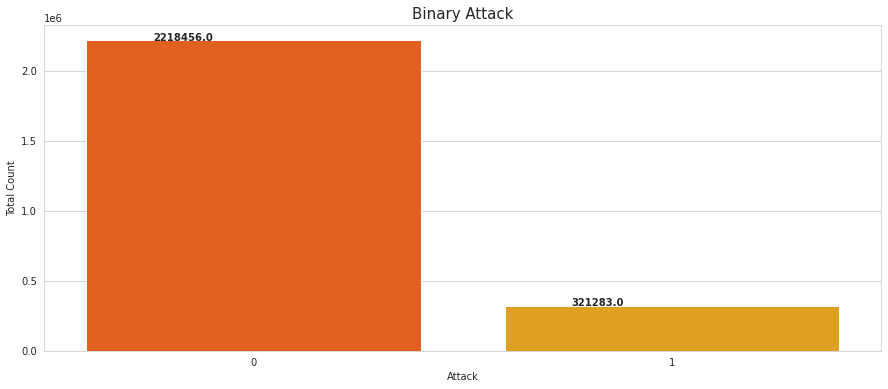

In [ ]:
sns.set_style("whitegrid")
bar,ax = plt.subplots(figsize=(15,6))
ax = sns.barplot(x=blabel['Label'], y=blabel['total'], data=blabel, ci=None, palette="autumn",orient='v', )
ax.set_title("Binary Attack", fontsize=15)
ax.set_xlabel ("Attack")
ax.set_ylabel ("Total Count")
for rect in ax.patches:
    ax.text (rect.get_x()  + rect.get_width() /5,rect.get_height(),"%.1f"% rect.get_height(), weight='bold' )
bar.savefig("attackcount.png");

## These four columns are categorical: 'attack_cat', 'state', 'service', 'proto'. Among them 'attack_cat' isn't a feature. These features are categorical but in integer form : 'is_sm_ips_ports', 'ct_state_ttl', 'is_ftp_login'.

## Lets Visulized them Graphically

## Multi Classification

In [ ]:
Mlabel = spark.sql("SELECT attack_cat, count(attack_cat) as total FROM UNSWs group by attack_cat order by total DESC")
Mlabel.show()

+---------------+-------+
|     attack_cat|  total|
+---------------+-------+
|         benign|2218456|
|        Generic| 215481|
|       Exploits|  44525|
|       Fuzzers |  19195|
|            DoS|  16353|
|Reconnaissance |  12228|
|        Fuzzers|   5051|
|       Analysis|   2677|
|       Backdoor|   1795|
| Reconnaissance|   1759|
|     Shellcode |   1288|
|      Backdoors|    534|
|      Shellcode|    223|
|          Worms|    174|
+---------------+-------+



In [ ]:
labels = Mlabel.toPandas()

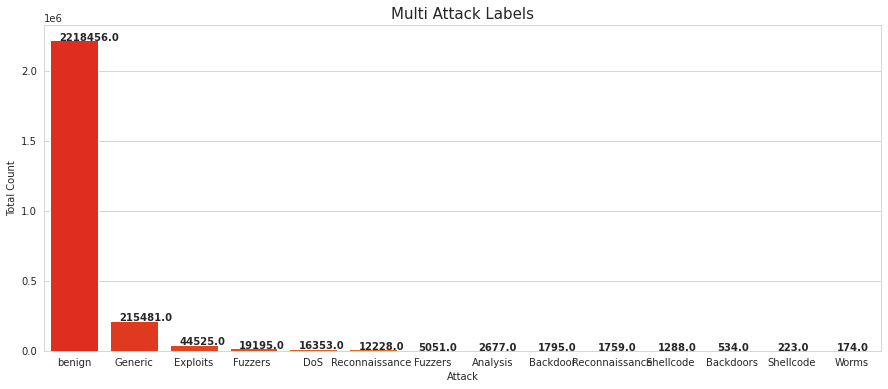

In [ ]:
sns.set_style("whitegrid")
bar,ax = plt.subplots(figsize=(15,6))
ax = sns.barplot(x=labels['attack_cat'], y=labels['total'], data=labels, ci=None, palette="autumn",orient='v', )
ax.set_title("Multi Attack Labels", fontsize=15)
ax.set_xlabel ("Attack")
ax.set_ylabel ("Total Count")
for rect in ax.patches:
    ax.text (rect.get_x()  + rect.get_width() /5,rect.get_height(),"%.1f"% rect.get_height(), weight='bold' )
bar.savefig("attackcount.png");

## Top 30 Viuslizing which Protocal was used more for attack

In [ ]:
vis = spark.sql("select "'attack_cat'","'proto'", count(*) as count from UNSWs where attack_cat != 'benign'\
          group by attack_cat,proto\
          order by count desc Limit 30")
vis.show()

+---------------+-----+------+
|     attack_cat|proto| count|
+---------------+-----+------+
|        Generic|  udp|210600|
|       Exploits|  tcp| 27443|
|       Fuzzers |  tcp| 12374|
|       Exploits| unas|  6532|
|Reconnaissance |  tcp|  5947|
|            DoS| unas|  5246|
|       Fuzzers |  udp|  5082|
|Reconnaissance |  udp|  4175|
|            DoS|  tcp|  3336|
|        Generic|  tcp|  3118|
|        Fuzzers|  tcp|  3100|
|       Exploits| ospf|  1504|
| Reconnaissance|  tcp|  1018|
|        Fuzzers|  udp|   961|
|            DoS| ospf|   944|
|       Analysis| unas|   926|
|       Exploits|  udp|   874|
|Reconnaissance | unas|   840|
|       Exploits| sctp|   739|
|        Generic| unas|   720|
+---------------+-----+------+
only showing top 20 rows



In [ ]:
vispd = vis.toPandas()

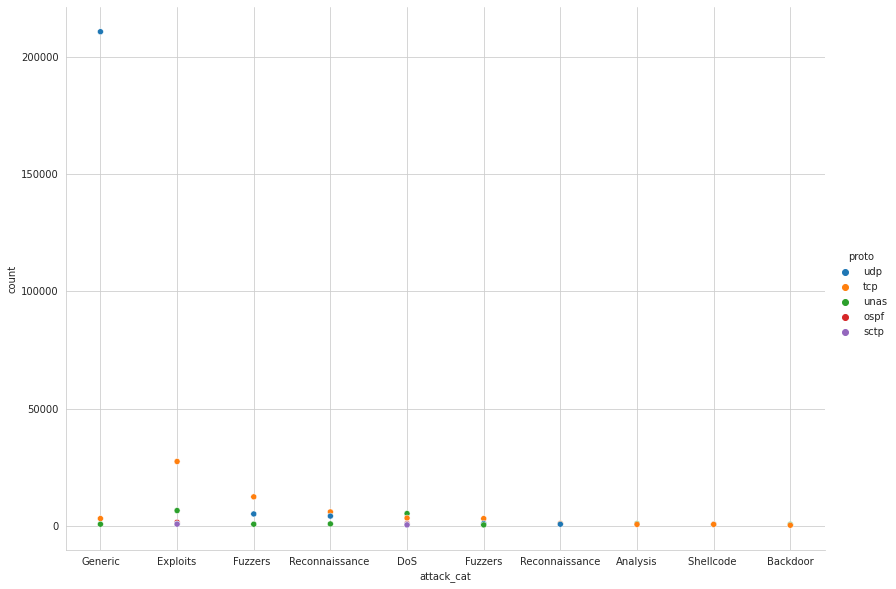

In [ ]:
sns.set_style('whitegrid')
sns.relplot(data=vispd, x="attack_cat", y="count", hue="proto", height=8.27, aspect=11.7/8.27)

##is_ftp_login
if the ftp session is accessed by user and password then 1 else 0. In most of the cases session has no user and password. However there are values 2 and 4 which should not be there so thats are removed

In [ ]:
vis = spark.sql("select "'is_ftp_login'","'label'", count(label) as count from UNSWs where is_ftp_login != 4 and is_ftp_login != 2 \
          group by is_ftp_login,label\
          order by count desc")
vis.show()

+------------+-----+-------+
|is_ftp_login|label|  count|
+------------+-----+-------+
|           0|    0|2176814|
|           0|    1| 319350|
|           1|    0|  41480|
|           1|    1|   1909|
+------------+-----+-------+



In [ ]:
vispd = vis.toPandas()

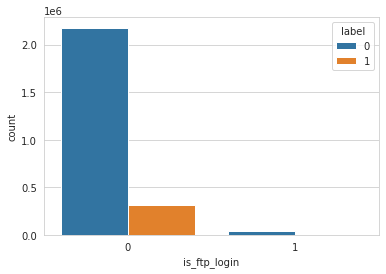

In [ ]:
sns.barplot(x="is_ftp_login", y="count", hue="label", data=vispd);

## ct_dst_ltm
Numerical feature.
No. of connections of the same destination address in 100 connections according to the last time.

* Range of values of this feature is about 0 to 70
* For normal data most of the values are between 0 to 10 and few from 10 to 20.
* For anomaly values are close to 0 and also there are values from 10 to 30.


In [ ]:
vispd_normal = spark.sql("select "'ct_dst_ltm'","'label'" from UNSWs where label == 0")

In [ ]:
vispd_anomaly = spark.sql("select "'ct_dst_ltm'","'label'" from UNSWs where label == 1")

In [ ]:
v1 = vispd_normal.toPandas()
v2 = vispd_anomaly.toPandas()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/dis

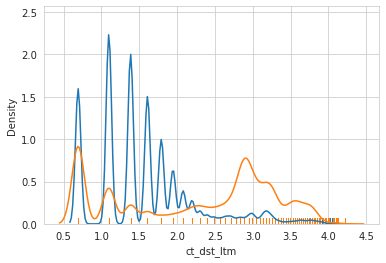

In [ ]:
sns.distplot(v1['ct_dst_ltm'].apply(np.log1p), label='normal', hist=False, rug=True)
sns.distplot(v2['ct_dst_ltm'].apply(np.log1p), label='anomaly', hist=False, rug=True)

## Dpkts
* Range of values for this feature is around 10,000
* Non-attck cat values are very close to 0. In log scale its upto 5.
* Attack cat values are widely distributed and has higher fraction around 2 and 3 in log1p graph

In [118]:
dpkts_normal = spark.sql("select "'dpkts'","'label'" from UNSWs where label == 0")

In [119]:
dpkts_anomaly = spark.sql("select "'dpkts'","'label'" from UNSWs where label == 1")

In [121]:
d1 = dpkts_normal.toPandas()
d2 = dpkts_anomaly.toPandas()

## Normal

In [ ]:
sns.distplot(d1['dpkts'], label='normal', hist=False, rug=True)
sns.distplot(d2['dpkts'], label='anomaly', hist=False, rug=True)

## Log1p

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/dis

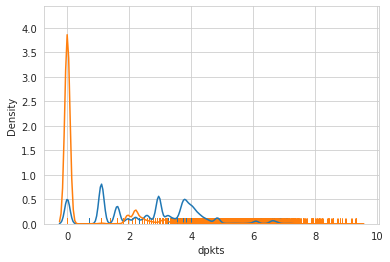

In [126]:
sns.distplot(d1['dpkts'].apply(np.log1p), label='normal', hist=False, rug=True)
sns.distplot(d2['dpkts'].apply(np.log1p), label='anomaly', hist=False, rug=True)

## Correlation

In [20]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

In [21]:
UNSW.printSchema()

root
 |-- srcip: string (nullable = true)
 |-- sport: integer (nullable = true)
 |-- dstip: string (nullable = true)
 |-- dsport: integer (nullable = true)
 |-- proto: string (nullable = true)
 |-- state: string (nullable = true)
 |-- dur: double (nullable = true)
 |-- sbytes: integer (nullable = true)
 |-- dbytes: integer (nullable = true)
 |-- sttl: integer (nullable = true)
 |-- dttl: integer (nullable = true)
 |-- sloss: integer (nullable = true)
 |-- dloss: integer (nullable = true)
 |-- service: string (nullable = true)
 |-- Sload: double (nullable = true)
 |-- Dload: double (nullable = true)
 |-- Spkts: integer (nullable = true)
 |-- Dpkts: integer (nullable = true)
 |-- swin: integer (nullable = true)
 |-- dwin: integer (nullable = true)
 |-- stcpb: long (nullable = true)
 |-- dtcpb: long (nullable = true)
 |-- smeansz: integer (nullable = true)
 |-- dmeansz: integer (nullable = true)
 |-- trans_depth: integer (nullable = true)
 |-- res_bdy_len: integer (nullable = true)
 |-- S

In [22]:
columns_to_drop = ['dstip', 'proto','state','service','attack_cat','srcip']
corr_df = UNSW.drop(*columns_to_drop)

In [23]:
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=corr_df.columns, outputCol=vector_col)
df_vector = assembler.transform(corr_df).select(vector_col)

In [24]:
matrix = Correlation.corr(df_vector, vector_col)

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


In [25]:
correlation = Correlation.corr(df_vector,vector_col,"pearson").collect()[0][0]

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


In [26]:
rows = correlation.toArray().tolist()
dfs = spark.createDataFrame(rows,corr_df.columns)

In [ ]:
dfs.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|               sport|              dsport|                 dur|              sbytes|          

## Extracting highly correlated features from the table

* sbytes, sloss

### 0.95 show that both model are highly positive correlated to each other

In [91]:
df.stat.corr("sbytes", "sloss")

0.9534933513109177

* dpkts, dbytes, dloss

## All three correlation again shows that features are highly correlated between each others

In [93]:
df.stat.corr("dpkts", "dbytes")

0.9708089992713627

In [94]:
df.stat.corr("dpkts", "dloss")

0.9921626706722774

In [117]:
df.stat.corr("dbytes", "Sload")

-0.06997697016490562

## Plotting a pair plot for these three columns

In [108]:
data = spark.sql("select "'dpkts'","'dbytes'","'dloss'" from UNSWs")

In [110]:
df_data = data.toPandas()

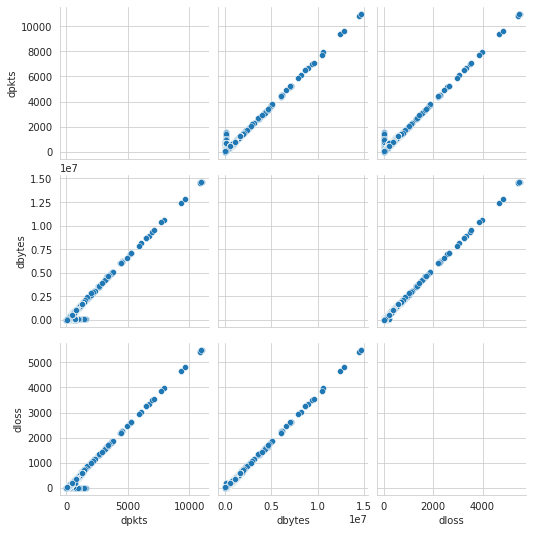

In [111]:
sns.set_style('whitegrid')
sns.pairplot(df_data, vars=['dpkts', 'dbytes', 'dloss'])
plt.show()

## Few More Highly correlated features

  * sttl, ct_state_ttl


In [101]:
df.stat.corr("sttl", "ct_state_ttl")

0.9060746751961302

* swin, dwin

In [99]:
df.stat.corr("swin", "dwin")

0.9972069954027378




* stime, Ltime


In [97]:
df.stat.corr("stime", "Ltime")

0.9999999997797562

* sport, dur

In [116]:
df.stat.corr("res_bdy_len", "dttl")             

0.007926275446871557

## Binary Classification

In [27]:
# one hot encoding and assembling
encoding_var = [i[0] for i in UNSW.dtypes if (i[1]=='string') & (i[0]!='Label')]
num_var = [i[0] for i in UNSW.dtypes if ((i[1]=='int') | (i[1]=='double')) & (i[0]!='Label')]

'''from string to interger'''
string_indexes = [StringIndexer(inputCol = c, outputCol = 'IDX_' + c, handleInvalid = 'keep') for c in encoding_var]
'''from interger to binary vectors'''
onehot_indexes = [OneHotEncoder(inputCols = ['IDX_' + c], outputCols = ['OHE_' + c]) for c in encoding_var]
## The input for the model should be binary vectors
assembler = VectorAssembler(inputCols = num_var + ['OHE_' + c for c in encoding_var], outputCol = "features")

In [28]:
fi_pipe = Pipeline(stages = string_indexes + onehot_indexes + [assembler])

## Transforming Dataset

In [29]:
mod = fi_pipe.fit(UNSW)

In [30]:
pred_train = mod.transform(UNSW)

## Training the Model

In [31]:
finaltrain = pred_train.select("features","Label")

In [32]:
finaltrain.show(5)

+--------------------+-----+
|            features|Label|
+--------------------+-----+
|(307,[0,1,2,3,4,5...|    0|
|(307,[0,1,2,3,4,5...|    0|
|(307,[0,1,2,3,4,5...|    0|
|(307,[0,1,2,3,4,5...|    0|
|(307,[0,1,2,3,4,5...|    0|
+--------------------+-----+
only showing top 5 rows



## RandomForest

## Train and Test Split

* Train Data 80%
* Test Data 20% 

In [33]:
#Split training and testing data
train_data,test_data = finaltrain.randomSplit([0.8,0.2])

## Model Training

In [34]:
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'Label')
## Train Data
rf = rf.fit(train_data)

## Prediction

In [35]:
#Prediction on Test Data
pred = rf.evaluate(test_data)

#Model Prediction
pred.predictions.show()

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


+--------------------+-----+--------------------+--------------------+----------+
|            features|Label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|(307,[0,1,2,3,4,5...|    0|[11.4265707037842...|[0.57132853518921...|       0.0|
|(307,[0,1,2,3,4,5...|    1|[4.71812695895370...|[0.23590634794768...|       1.0|
|(307,[0,1,2,3,4,5...|    1|[3.14020902418251...|[0.15701045120912...|       1.0|
|(307,[0,1,2,3,4,5...|    1|[2.64945060109895...|[0.13247253005494...|       1.0|
|(307,[0,1,2,3,4,5...|    1|[4.71812695895370...|[0.23590634794768...|       1.0|
|(307,[0,1,2,3,4,5...|    1|[3.55246108179416...|[0.17762305408970...|       1.0|
|(307,[0,1,2,3,4,5...|    1|[4.08178176780875...|[0.20408908839043...|       1.0|
|(307,[0,1,2,3,4,5...|    1|[5.74220893410903...|[0.28711044670545...|       1.0|
|(307,[0,1,2,3,4,5...|    1|[4.88487738206208...|[0.24424386910310...|       1.0|
|(307,[0,1,2,3,4

In [36]:
testDF2 = pred.predictions.withColumnRenamed("Label", "label")

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


## Evaluation

In [37]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

MultiEValuator = MulticlassClassificationEvaluator(metricName="accuracy")
print("Accuracy:", MultiEValuator.evaluate(testDF2)*100)

Accuracy: 99.9936932515821


## Confusion Matrix

In [38]:
y_test = testDF2.select('label').toPandas()
y_test_pred = testDF2.select('prediction').toPandas()

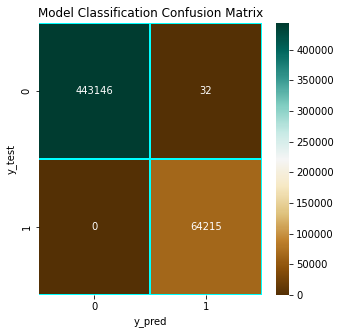

In [39]:
from sklearn.metrics import confusion_matrix,roc_curve,auc
# Creating the confusion matrix:
gn_cm = confusion_matrix(y_test, y_test_pred)

# Visualization:
f, ax = plt.subplots(figsize=(5,5))
sns.heatmap(gn_cm, annot=True, linewidth=0.7, linecolor='cyan', fmt='.0f', ax=ax, cmap='BrBG')
plt.title('Model Classification Confusion Matrix')
plt.xlabel('y_pred')
plt.ylabel('y_test')
plt.show()

## CLassification Report

In [40]:
print("True Positive Rate {}".format(pred.weightedTruePositiveRate))
print("False Positive Rate {}".format(pred.weightedFalsePositiveRate))
print("Precision {}".format(pred.weightedPrecision))
print("Recall {}".format(pred.weightedRecall))
print("F1 Score {}".format(pred.weightedFMeasure()))

True Positive Rate 0.999936932515821
False Positive Rate 9.13826610650802e-06
Precision 0.9999369639283305
Recall 0.999936932515821
F1 Score 0.9999369392324049


## Multi-Classfication

In [45]:
pred_train.show(2)

+----------+-----+-------------+------+-----+-----+----------+------+------+----+----+-----+-----+-------+---------+---------+-----+-----+----+----+----------+----------+-------+-------+-----------+-----------+---------+---------+----------+----------+---------+--------+------------+------------+-------+---------------+------------+----------------+------------+----------+----------+----------+----------+-----------+----------------+----------------+--------------+----------+-----+---------+---------+---------+---------+-----------+--------------+--------------+--------------+---------------+--------------+--------------+--------------+--------------------+
|     srcip|sport|        dstip|dsport|proto|state|       dur|sbytes|dbytes|sttl|dttl|sloss|dloss|service|    Sload|    Dload|Spkts|Dpkts|swin|dwin|     stcpb|     dtcpb|smeansz|dmeansz|trans_depth|res_bdy_len|     Sjit|     Djit|     Stime|     Ltime|  Sintpkt| Dintpkt|      tcprtt|      synack| ackdat|is_sm_ips_ports|ct_state_ttl|

In [46]:
multitrain = pred_train.select("features","IDX_attack_cat")

In [47]:
multitraindf = multitrain.withColumnRenamed("IDX_attack_cat", "label")

In [48]:
#Split training and testing data
train_data,test_data = multitraindf.randomSplit([0.8,0.2])

## Train Model

In [64]:
from pyspark.ml.classification import OneVsRest

In [65]:
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
ovr = OneVsRest(classifier=rf)
## Train Data
rf = ovr.fit(multitraindf)

## Prediction

In [ ]:
#Prediction on Test Data
pred = rf.transform(multitraindf)

#Model Prediction
pred.show(5)

## Accuracy

In [71]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

MultiEValuator = MulticlassClassificationEvaluator(metricName="accuracy")
print("Accuracy:", MultiEValuator.evaluate(pred)*100)

Accuracy: 99.627008917058


In [72]:
y_test = pred.select('label').toPandas()
y_test_pred = pred.select('prediction').toPandas()

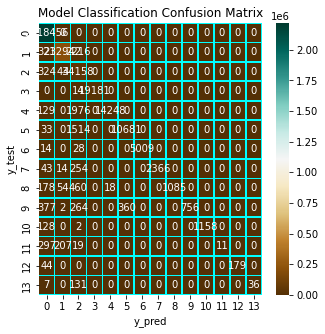

In [73]:
from sklearn.metrics import confusion_matrix,roc_curve,auc
# Creating the confusion matrix:
gn_cm = confusion_matrix(y_test, y_test_pred)

# Visualization:
f, ax = plt.subplots(figsize=(5,5))
sns.heatmap(gn_cm, annot=True, linewidth=0.7, linecolor='cyan', fmt='.0f', ax=ax, cmap='BrBG')
plt.title('Model Classification Confusion Matrix')
plt.xlabel('y_pred')
plt.ylabel('y_test')
plt.show()

## Classification Report

 * Precision
 * Recall
 * F1-Score
 * True Positve Rate
 * False Positive Rate

In [79]:
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(y_test, y_test_pred, average='weighted')

(0.9965986374172491, 0.9962700891705801, 0.9960808899610042, None)

In [87]:
TP = gn_cm[0][0]
FP = gn_cm[1][0]
TPR = TP/(TP+FN)
FPR = FP/(FP+TN)
print("True Positive rate is:", TPR)
print("True Positive rate is:", FPR)

True Positive rate is: 1.0
True Positive rate is: 0.0015145476285372658


In [77]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00   2218456
         1.0       1.00      0.99      0.99    215481
         2.0       0.87      0.99      0.92     44525
         3.0       1.00      1.00      1.00     19195
         4.0       1.00      0.87      0.93     16353
         5.0       0.97      0.87      0.92     12228
         6.0       1.00      0.99      1.00      5051
         7.0       1.00      0.88      0.94      2677
         8.0       1.00      0.60      0.75      1795
         9.0       1.00      0.43      0.60      1759
        10.0       1.00      0.90      0.95      1288
        11.0       1.00      0.02      0.04       534
        12.0       1.00      0.80      0.89       223
        13.0       1.00      0.21      0.34       174

    accuracy                           1.00   2539739
   macro avg       0.99      0.75      0.81   2539739
weighted avg       1.00      1.00      1.00   2539739

